# Patron de Puntos

In [9]:
import warnings
warnings.filterwarnings('ignore')

import descartes
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import pysal
import seaborn as sbn
import contextily as ctx
from sklearn.cluster import KMeans, DBSCAN
from matplotlib_map_utils.core.north_arrow import NorthArrow, north_arrow
from matplotlib_map_utils.core.scale_bar import ScaleBar, scale_bar
import plotly.express as px
import plotly.graph_objects as go
pd.set_option('display.max_columns', None)


In [2]:
gdf = gpd.read_file("https://github.com/algarciach/AnalisisGeoespacial/raw/main/Covid19_model/Data/covid19_municipios_antioquia.gpkg")
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   codigo_municipio     125 non-null    object  
 1   nombre_municipio     125 non-null    object  
 2   codigo_subregion     125 non-null    object  
 3   nombre_subregion     125 non-null    object  
 4   area_municipio       125 non-null    float64 
 5   altitud              125 non-null    float64 
 6   temperatura          125 non-null    float64 
 7   humedad_relativa     125 non-null    float64 
 8   poblacion            125 non-null    int64   
 9   densidad             125 non-null    float64 
 10  muertes_covid19      125 non-null    int64   
 11  recuperados_covid19  125 non-null    int64   
 12  cfr                  125 non-null    float64 
 13  geometry             125 non-null    geometry
dtypes: float64(6), geometry(1), int64(3), object(4)
memory usage: 13.8

### Centroides

In [3]:
points_covid19_antioquia = gdf.copy()
points_covid19_antioquia["geometry"] = gdf.geometry.centroid
points_covid19_antioquia = points_covid19_antioquia.set_geometry("geometry")
print(points_covid19_antioquia.crs)

EPSG:4326


In [4]:
points_covid19_antioquia.info()
points_covid19_antioquia.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   codigo_municipio     125 non-null    object  
 1   nombre_municipio     125 non-null    object  
 2   codigo_subregion     125 non-null    object  
 3   nombre_subregion     125 non-null    object  
 4   area_municipio       125 non-null    float64 
 5   altitud              125 non-null    float64 
 6   temperatura          125 non-null    float64 
 7   humedad_relativa     125 non-null    float64 
 8   poblacion            125 non-null    int64   
 9   densidad             125 non-null    float64 
 10  muertes_covid19      125 non-null    int64   
 11  recuperados_covid19  125 non-null    int64   
 12  cfr                  125 non-null    float64 
 13  geometry             125 non-null    geometry
dtypes: float64(6), geometry(1), int64(3), object(4)
memory usage: 13.8

codigo_municipio nombre_municipio codigo_subregion nombre_subregion  \
0            05001         MEDELLIN               01  VALLE DE ABURRA   
1            05002        ABEJORRAL               07          ORIENTE   
2            05004         ABRIAQUI               06        OCCIDENTE   
3            05021       ALEJANDRIA               07          ORIENTE   
4            05030            AMAGA               08         SUROESTE   

   area_municipio      altitud  temperatura  humedad_relativa  poblacion  \
0      374.834005  2059.003077    18.203481         80.582299    2616335   
1      507.141095  1947.128522    17.845754         80.265871      21468   
2      296.894050  2371.335448    15.912880         85.717115       2855   
3      128.932153  1545.100614    20.538783         80.036523       4955   
4       84.132477  1513.740970    21.093243         78.477931      32412   

      densidad  muertes_covid19  recuperados_covid19       cfr  \
0  6979.983054            10354               537729  1.889130   
1    42.331415               24                  579  3.980100   
2     9.616225                1                   78  1.265823   
3    38.431065                6                  176  3.296703   
4   385.249562               54                 1440  3.614458   

                    geometry  
0  POINT (-75.61104 6.25759)  
1  POINT (-75.43847 5.80373)  
2  POINT (-76.08598 6.62755)  
3   POINT (-75.0906 6.36553)  
4    POINT (-75.708 6.03292)

Para efectos del análisis de eventos, se construye una variable binaria que indica la ocurrencia de un evento crítico. Esta toma el valor de 1 si la tasa de letalidad (CFR) supera el umbral del 3% y 0 en caso contrario.

In [6]:
points_covid19_antioquia["evento_CFR"] = points_covid19_antioquia["cfr"].apply(lambda x: 1 if x > 3 else 0)
points_covid19_antioquia.info()
points_covid19_antioquia["evento_CFR"].value_counts()


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   codigo_municipio     125 non-null    object  
 1   nombre_municipio     125 non-null    object  
 2   codigo_subregion     125 non-null    object  
 3   nombre_subregion     125 non-null    object  
 4   area_municipio       125 non-null    float64 
 5   altitud              125 non-null    float64 
 6   temperatura          125 non-null    float64 
 7   humedad_relativa     125 non-null    float64 
 8   poblacion            125 non-null    int64   
 9   densidad             125 non-null    float64 
 10  muertes_covid19      125 non-null    int64   
 11  recuperados_covid19  125 non-null    int64   
 12  cfr                  125 non-null    float64 
 13  geometry             125 non-null    geometry
 14  evento_CFR           125 non-null    int64   
dtypes: float64(6), 

evento_CFR
0    67
1    58
Name: count, dtype: int64

In [7]:
# + tags=["hide-output"]
%pip install geopandas
%pip install plotly
%pip install matplotlib-map-utils

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Visualization

### Dots on Map

In [67]:
# Extract coordinates from geometry
points_covid19_antioquia["longitude"] = points_covid19_antioquia.geometry.x
points_covid19_antioquia["latitude"] = points_covid19_antioquia.geometry.y

# Filter points with evento_CFR > 3
CFR3_points = points_covid19_antioquia[points_covid19_antioquia["evento_CFR"] == 1]

In [111]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.scatter_mapbox(
    CFR3_points,
    lat=CFR3_points.latitude,
    lon=CFR3_points.longitude,
    size_max=15,
    zoom=6.3,
    height=600
)

fig.update_layout(
    mapbox_style="carto-positron",
    mapbox_zoom=6.3,
    mapbox_center={"lat": 6.25, "lon": -75.5},
    margin={"r": 0, "t": 0, "l": 0, "b": 0},
    mapbox=dict(
        bearing=0,
        pitch=0,
        center=dict(lat=6.25, lon=-75.5)
    )
)

fig.show()


### Municipios con CFR > 3

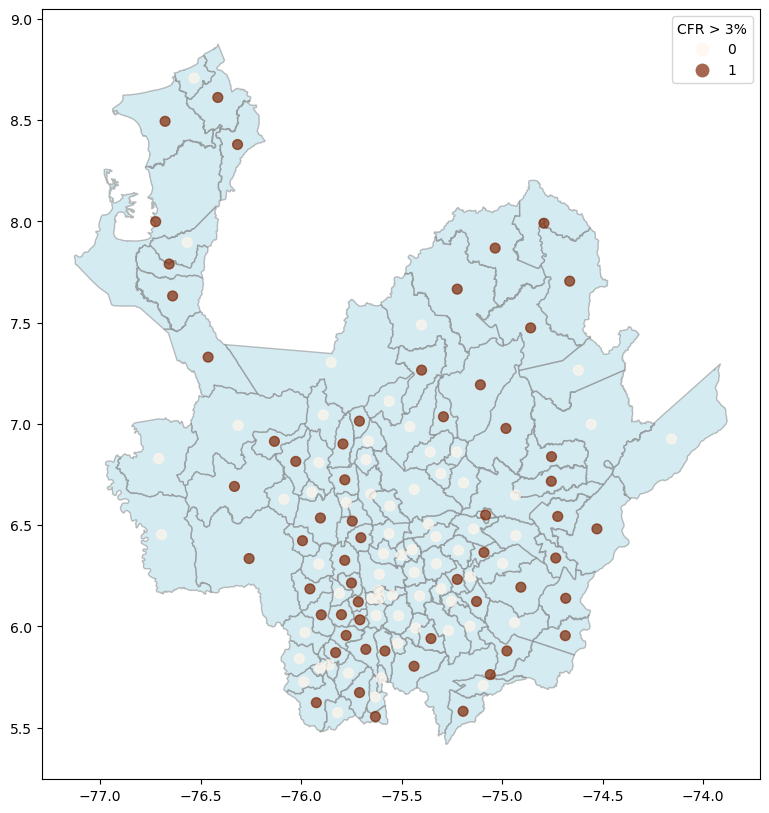

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color='lightblue', edgecolor='grey', alpha=0.5)
points_covid19_antioquia.plot(
    ax=ax, column='evento_CFR', categorical=True, legend=True,
    legend_kwds={'title': 'CFR > 3%'},
    cmap='Oranges', markersize=50, alpha=0.7
    )
plt.show()

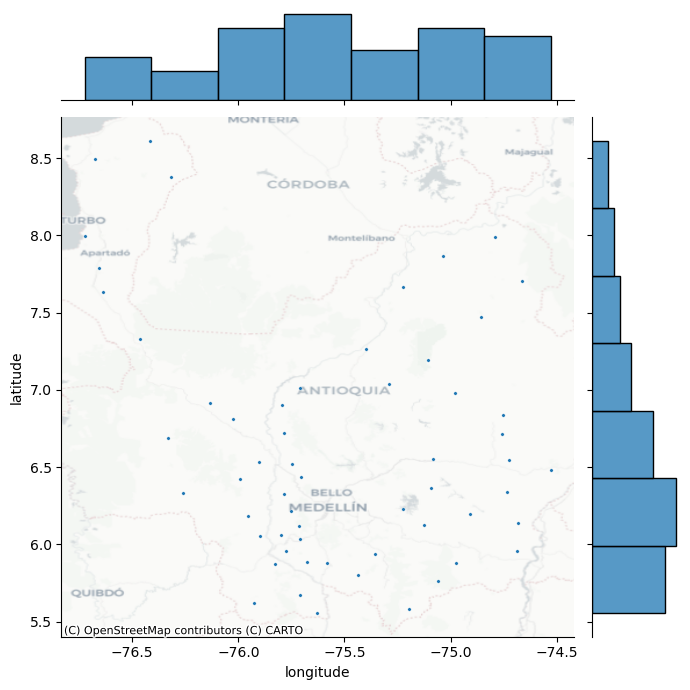

In [80]:
import contextily as ctx
joint_axes = sbn.jointplot(x='longitude', y='latitude', data=CFR3_points, s=6, height=7)
ctx.add_basemap(
    joint_axes.ax_joint, crs=CFR3_points.crs,
    source=ctx.providers.CartoDB.Positron)

### Irregular lattices

Usaremos las areas de las subregiones para determinar la intensidad de puntos en las zonas

In [81]:
subregiones_antioquia =  gdf.dissolve(by="codigo_subregion", as_index=False).reset_index()

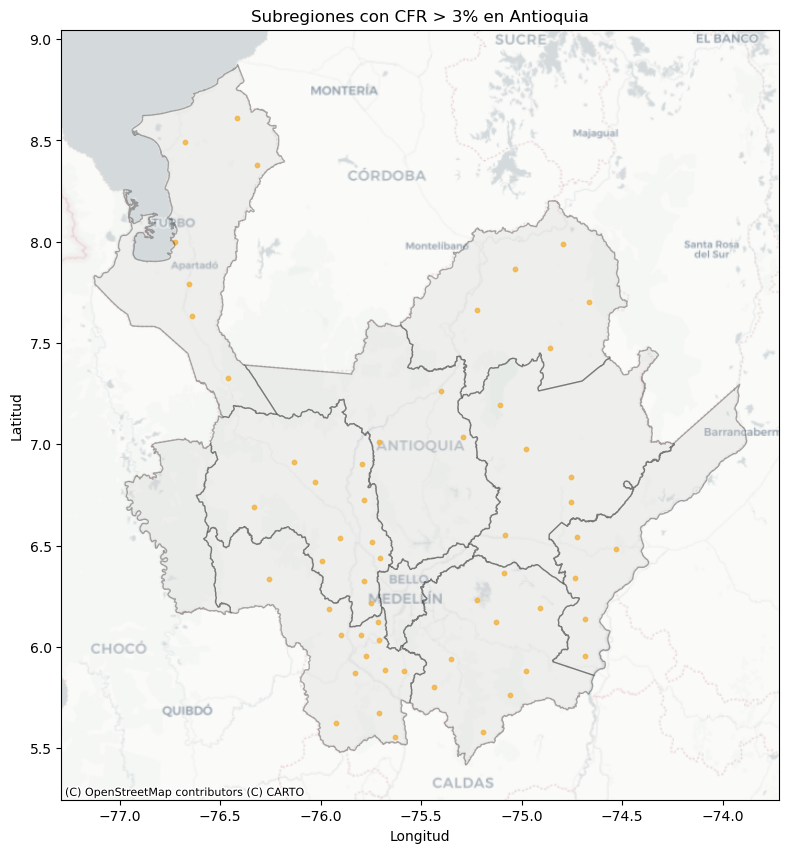

In [94]:
ax = CFR3_points.plot.scatter(
    x='longitude', y='latitude', s=10, 
    c='orange', alpha=0.8, figsize=(10, 10)
)
subregiones_antioquia.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.3)
ax.set_title('Subregiones con CFR > 3% en Antioquia')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ctx.add_basemap(
    ax, crs=CFR3_points.crs,
    source=ctx.providers.CartoDB.Positron)
plt.show()


Determinar cuantos municipios con CFR > 3 por subregion

In [98]:
CFR3_points_by_subregion = CFR3_points.groupby('codigo_subregion').size().reset_index(name='count')

suberegiones = subregiones_antioquia.merge(
    CFR3_points_by_subregion, on='codigo_subregion', how='left'
)
suberegiones['count'] = suberegiones['count'].fillna(0)


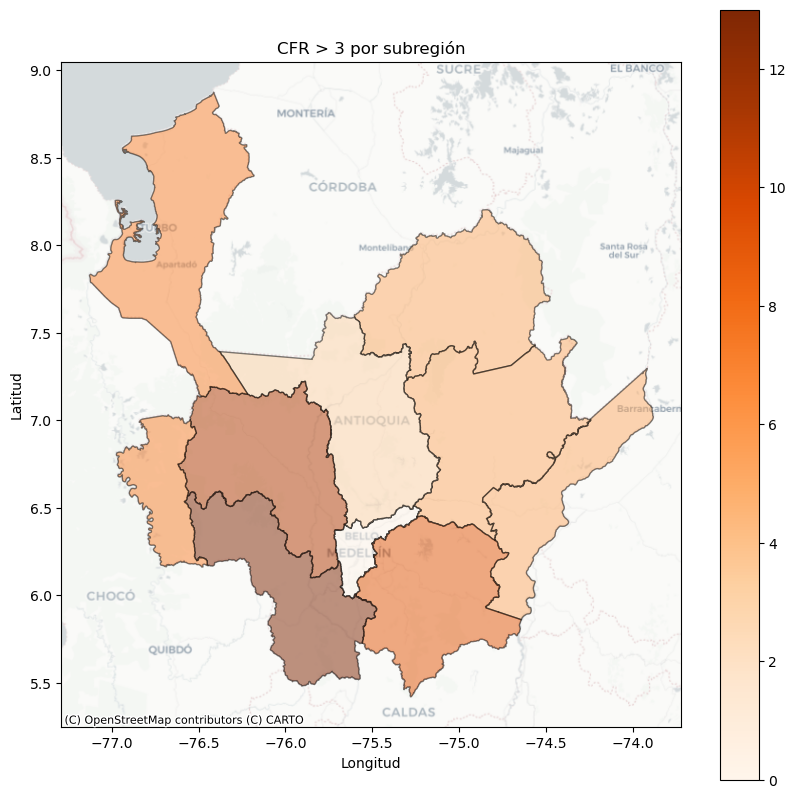

In [100]:
fig, ax = plt.subplots(figsize=(10, 10))
suberegiones.plot(
    ax=ax, column='count', cmap='Oranges', legend=True,
    edgecolor='black', alpha=0.5
)
ax.set_title('CFR > 3 por subregión')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ctx.add_basemap(
    ax, crs=suberegiones.crs,
    source=ctx.providers.CartoDB.Positron)
plt.show()

### Regular lattices: Hex-binning

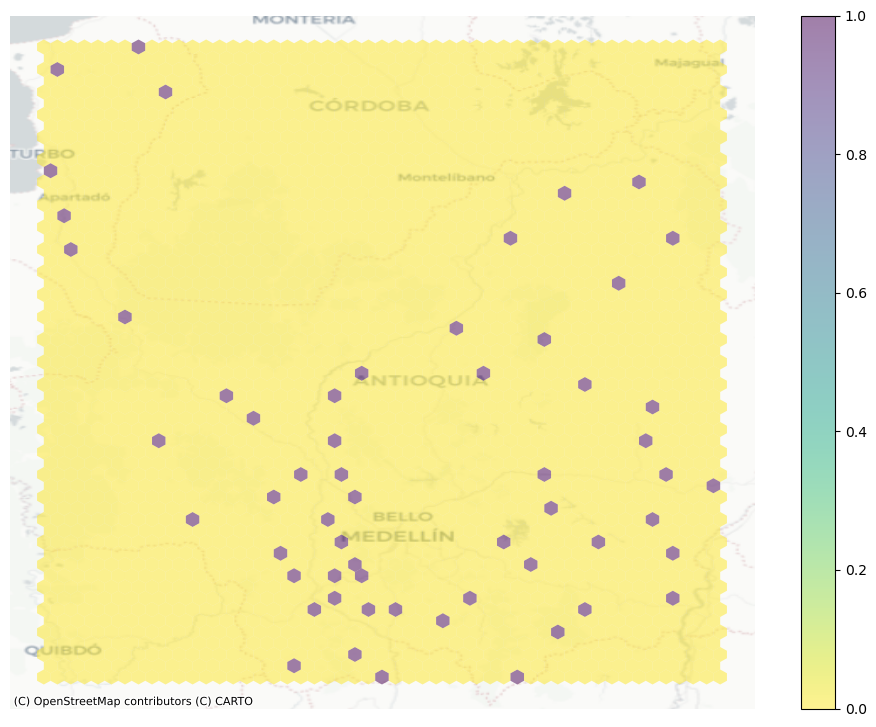

In [107]:
f, ax = plt.subplots(1, figsize=(12, 9))
hb = ax.hexbin(
    CFR3_points.longitude, CFR3_points.latitude,
    gridsize=50, 
    linewidths=0,
    alpha=0.5,
    cmap='viridis_r',
)

ctx.add_basemap(
    ax, crs="EPSG:4326",
    source=ctx.providers.CartoDB.Positron)

plt.colorbar(hb) 

ax.set_axis_off()   


### Kernel Density Estimation (KDE)

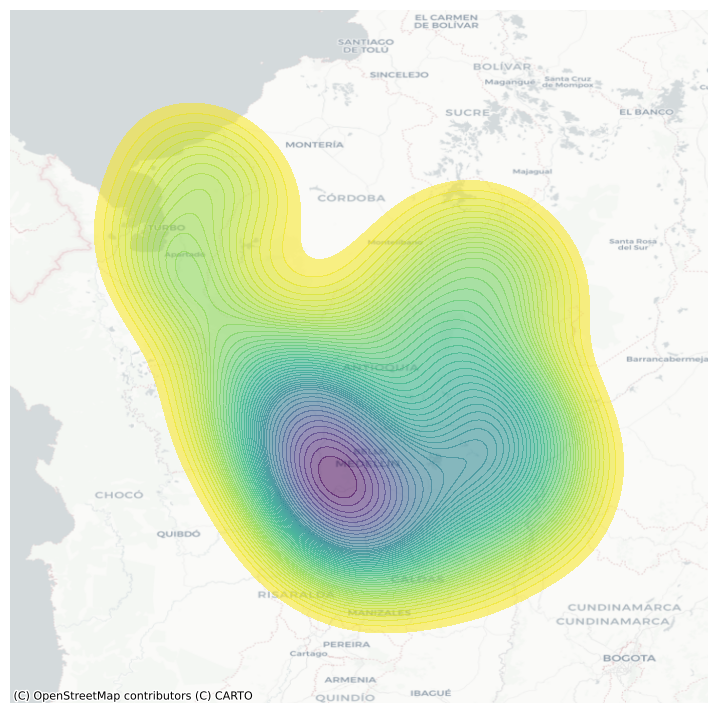

In [117]:
f, ax = plt.subplots(1, figsize=(9, 9))

sbn.kdeplot(
    x=CFR3_points.longitude, y=CFR3_points.latitude,
    fill=True, alpha=0.55, levels=50,
    cmap='viridis_r', ax=ax
)
ctx.add_basemap(
    ax, crs="EPSG:4326",
    source=ctx.providers.CartoDB.Positron)
ax.set_axis_off()


### Centrography

#### Tendency

In [119]:
from pointpats import centrography

In [124]:
coords = np.column_stack((CFR3_points.longitude, CFR3_points.latitude))

mean_center = centrography.mean_center(coords)
med_center = centrography.euclidean_median(coords)

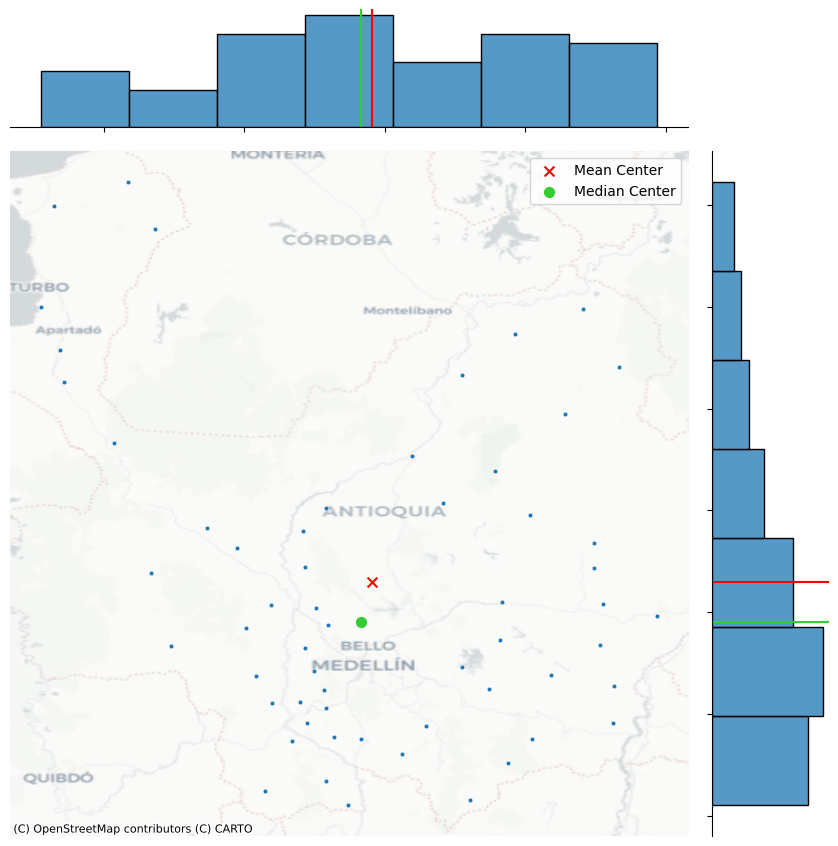

In [135]:
joint_axes = sbn.jointplot(
    x=CFR3_points.longitude, y=CFR3_points.latitude,
    s=10, height=9)
joint_axes.ax_joint.scatter(*mean_center, color='red', marker='x', s=50, label='Mean Center')
joint_axes.ax_marg_x.axvline(mean_center[0], color='red')
joint_axes.ax_marg_y.axhline(mean_center[1], color='red')

joint_axes.ax_joint.scatter(*med_center, color='limegreen', marker='o', s=50, label='Median Center')
joint_axes.ax_marg_x.axvline(med_center[0], color='limegreen')
joint_axes.ax_marg_y.axhline(med_center[1], color='limegreen')

joint_axes.ax_joint.legend()

ctx.add_basemap(joint_axes.ax_joint, crs="EPSG:4326", source=ctx.providers.CartoDB.Positron)

joint_axes.ax_joint.set_axis_off()

plt.show()

### Dispersion

In [137]:
centrography.std_distance(coords)

np.float64(0.975383555052916)

### Standard Deviational Ellipse

In [140]:
major, minor, rotation = centrography.ellipse(
    coords, 
)

In [141]:
major, minor, rotation

(np.float64(0.7840363917636705),
 np.float64(1.0009044428123037),
 np.float64(-0.381593606028805))

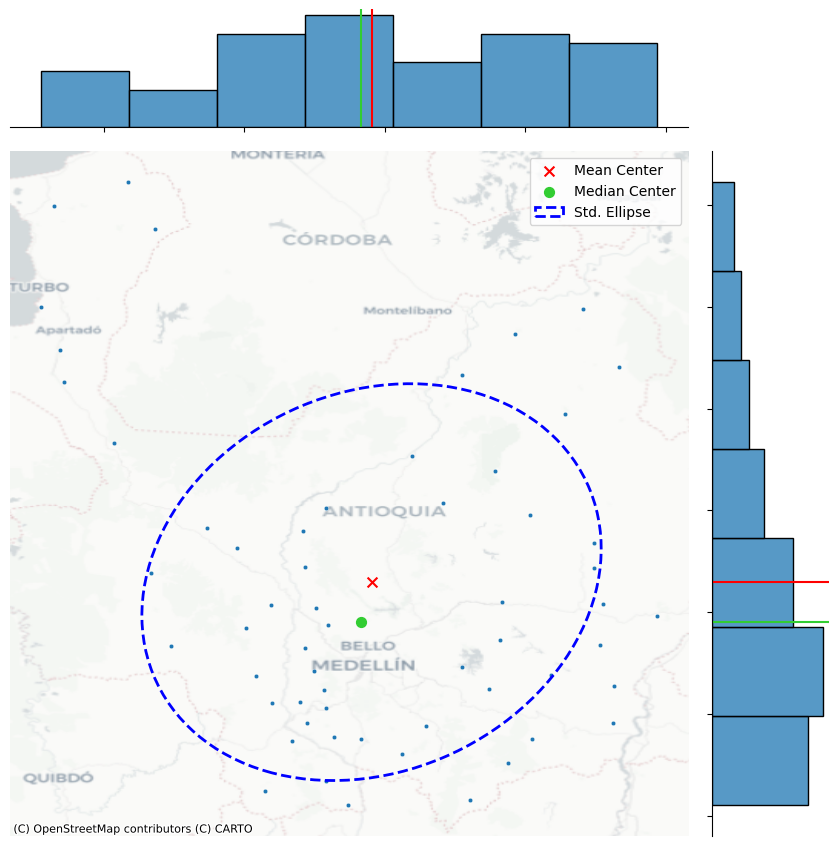

In [145]:
# Plot
joint_axes = sbn.jointplot(
    x=CFR3_points.longitude, y=CFR3_points.latitude,
    s=10, height=9
)

# Add mean center
joint_axes.ax_joint.scatter(*mean_center, color='red', marker='x', s=50, label='Mean Center')
joint_axes.ax_marg_x.axvline(mean_center[0], color='red')
joint_axes.ax_marg_y.axhline(mean_center[1], color='red')

# Add median center
joint_axes.ax_joint.scatter(*med_center, color='limegreen', marker='o', s=50, label='Median Center')
joint_axes.ax_marg_x.axvline(med_center[0], color='limegreen')
joint_axes.ax_marg_y.axhline(med_center[1], color='limegreen')

# Add the ellipse
ellipse = Ellipse(
    xy=mean_center,
    width=major * 2,
    height=minor * 2,
    angle=np.rad2deg(rotation),  # Convert radians to degrees
    edgecolor='blue',
    facecolor='none',
    linestyle='--',
    linewidth=2,
    label='Std. Ellipse'
)
joint_axes.ax_joint.add_patch(ellipse)

# Legend
joint_axes.ax_joint.legend()

# Add basemap
ctx.add_basemap(joint_axes.ax_joint, crs="EPSG:4326", source=ctx.providers.CartoDB.Positron)

# Hide axis
joint_axes.ax_joint.set_axis_off()
plt.show()


### Extent

In [148]:
print(coords)

[[-75.43847449   5.80372897]
 [-75.09059702   6.36553412]
 [-75.7080031    6.03292199]
 [-74.98127311   6.97769068]
 [-75.92459671   5.62395126]
 [-75.71594966   6.1214303 ]
 [-75.10848962   7.19311041]
 [-75.90426747   6.53570773]
 [-76.41478301   8.61138712]
 [-75.95649246   6.18578361]
 [-75.22369249   7.66515825]
 [-75.99351498   6.42346364]
 [-75.29224952   7.03542947]
 [-76.02689633   6.81495037]
 [-74.73354817   6.33797388]
 [-75.63081024   5.55526547]
 [-76.65668414   7.78916729]
 [-75.03501878   7.86794983]
 [-76.63964213   7.63166564]
 [-75.08253096   6.55008115]
 [-75.90014678   6.05746868]
 [-75.78331099   6.32645515]
 [-74.66427699   7.70463362]
 [-75.67837372   5.88716956]
 [-76.33198554   6.69136668]
 [-75.12763646   6.12338072]
 [-75.7497221    6.21452562]
 [-75.35429023   5.94043468]
 [-75.78300046   6.72399093]
 [-74.72370656   6.54330091]
 [-76.46302608   7.32954   ]
 [-75.19457019   5.58127531]
 [-76.67699198   8.4937355 ]
 [-74.79242149   7.99046768]
 [-75.22350906

In [150]:
convex_hull_vertices  = centrography.hull(coords)
print(convex_hull_vertices)

[[-74.68620541   5.95483902]
 [-74.5287421    6.48192227]
 [-74.66427699   7.70463362]
 [-74.79242149   7.99046768]
 [-76.41478301   8.61138712]
 [-76.67699198   8.4937355 ]
 [-76.72380317   7.99837236]
 [-76.63964213   7.63166564]
 [-76.25906482   6.33534134]
 [-75.92459671   5.62395126]
 [-75.63081024   5.55526547]
 [-75.19457019   5.58127531]]


In [151]:
import libpysal

In [152]:
alpha_shape, alpha, circs = libpysal.cg.alpha_shape_auto(coords, return_circles=True)

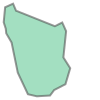

In [153]:
alpha_shape

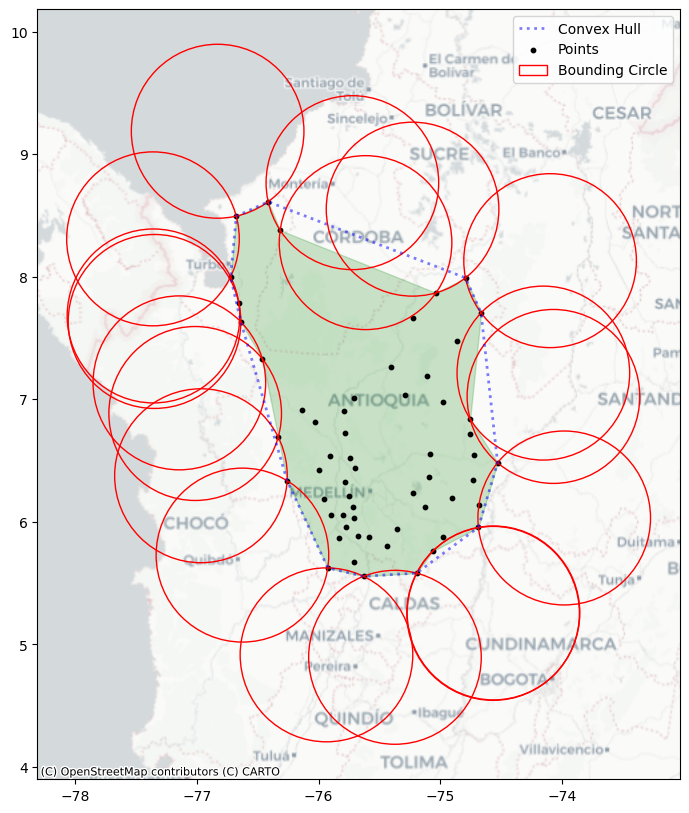

In [156]:
from shapely.geometry import Polygon
# Create GeoSeries for alpha shape and convex hull
gdf_alpha = gpd.GeoSeries([alpha_shape], crs="EPSG:4326")
gdf_hull = gpd.GeoSeries([Polygon(convex_hull_vertices)], crs="EPSG:4326")

#create figure and axis
fig, ax = plt.subplots(1,1, figsize=(10, 10))

# Plot alpha shape green and convex hull blue
gdf_alpha.plot(ax=ax, color='green', edgecolor='green', label='Alpha Shape', alpha=0.2)
gdf_hull.boundary.plot(ax=ax, color='blue', linestyle=':', linewidth=2, label='Convex Hull', alpha=0.5)

# Plot points
ax.scatter(*coords.T, color='k', s=10, label='Points', marker='o')

# Plor circles
for i, circle in enumerate(circs):
    label = 'Bounding Circle' if i == 0 else None
    ax.add_patch(
        plt.Circle(
            circle, 
            radius=alpha, 
            facecolor='none', 
            edgecolor='r', 
            label=label
        )
    )
    
# Add basemap
ctx.add_basemap(
    ax, crs="EPSG:4326",
    source=ctx.providers.CartoDB.Positron)

plt.legend()
plt.show()

In [157]:
min_rot_rect = centrography.minimum_rotated_rectangle(coords)

min_rect_vertices = centrography.minimum_bounding_rectangle(coords)

(center_x, center_y), radius = centrography.minimum_bounding_circle(coords)

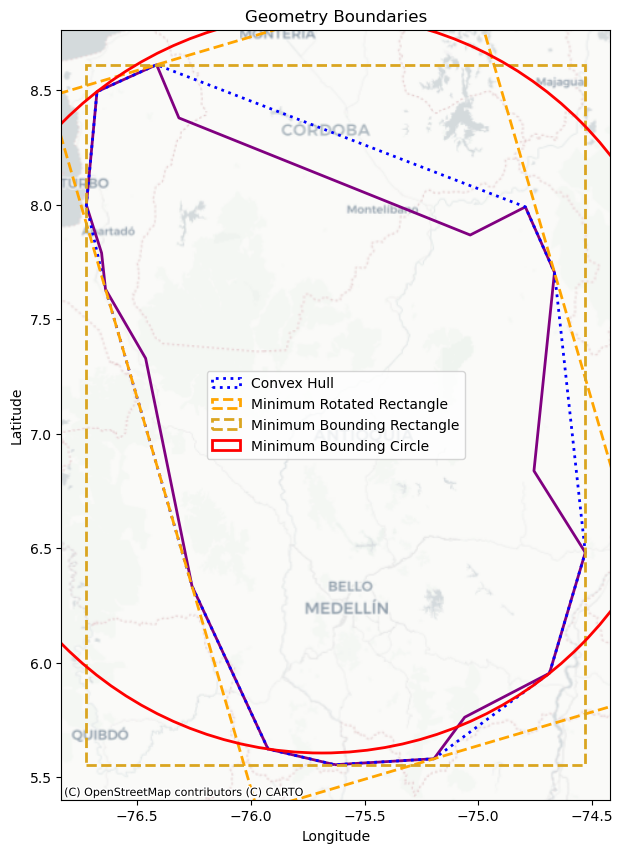

In [161]:
from shapely.geometry import Polygon, Point
from matplotlib.patches import Polygon as MplPolygon, Rectangle, Circle

# GeoSeries for the alpha shape
gdf_alpha = gpd.GeoSeries([alpha_shape], crs="EPSG:4326")

# Create figure and axis
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot alpha shape in purple
gdf_alpha.plot(ax=ax, facecolor='none', edgecolor='purple', label='Alpha Shape', linewidth=2)

# Plot convex hull patch blue
convex_patch = MplPolygon(
    convex_hull_vertices, 
    closed=True, 
    edgecolor='blue',
    facecolor='none', 
    linestyle=':', 
    linewidth=2, 
    label='Convex Hull'
)
ax.add_patch(convex_patch)

# Plot minimum rotated rectangle in orange
rot_rect_patch = MplPolygon(
    min_rot_rect, 
    closed=True, 
    edgecolor='orange',
    facecolor='none', 
    linestyle='--', 
    linewidth=2, 
    label='Minimum Rotated Rectangle'
)
ax.add_patch(rot_rect_patch)

# Plot minimum bounding rectangle in (goldenrod dashed)
xmin, ymin, xmax, ymax = min_rect_vertices
rect_width = xmax - xmin
rect_height = ymax - ymin

bbox_patch = Rectangle(
    (xmin, ymin), 
    width= rect_width, 
    height= rect_height, 
    edgecolor='goldenrod',
    facecolor='none', 
    linestyle='dashed', 
    linewidth=2, 
    label='Minimum Bounding Rectangle'
)
ax.add_patch(bbox_patch)

# Plot minimum bounding circle in red
circle_patch = Circle(
    (center_x, center_y), 
    radius=radius, 
    edgecolor='red',
    facecolor='none', 
    linewidth=2, 
    label='Minimum Bounding Circle'
)
ax.add_patch(circle_patch)

# Add basemap
ctx.add_basemap(
    ax, crs="EPSG:4326",
    source=ctx.providers.CartoDB.Positron)

ax.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geometry Boundaries')
plt.show()

## Randomness & Clustering

In [162]:
from pointpats import distance_statistics, QStatistic, random, PointPattern

In [163]:
coords

array([[-75.43847449,   5.80372897],
       [-75.09059702,   6.36553412],
       [-75.7080031 ,   6.03292199],
       [-74.98127311,   6.97769068],
       [-75.92459671,   5.62395126],
       [-75.71594966,   6.1214303 ],
       [-75.10848962,   7.19311041],
       [-75.90426747,   6.53570773],
       [-76.41478301,   8.61138712],
       [-75.95649246,   6.18578361],
       [-75.22369249,   7.66515825],
       [-75.99351498,   6.42346364],
       [-75.29224952,   7.03542947],
       [-76.02689633,   6.81495037],
       [-74.73354817,   6.33797388],
       [-75.63081024,   5.55526547],
       [-76.65668414,   7.78916729],
       [-75.03501878,   7.86794983],
       [-76.63964213,   7.63166564],
       [-75.08253096,   6.55008115],
       [-75.90014678,   6.05746868],
       [-75.78331099,   6.32645515],
       [-74.66427699,   7.70463362],
       [-75.67837372,   5.88716956],
       [-76.33198554,   6.69136668],
       [-75.12763646,   6.12338072],
       [-75.7497221 ,   6.21452562],
 

In [164]:
random_pattern = random.poisson(coords, size=len(coords))

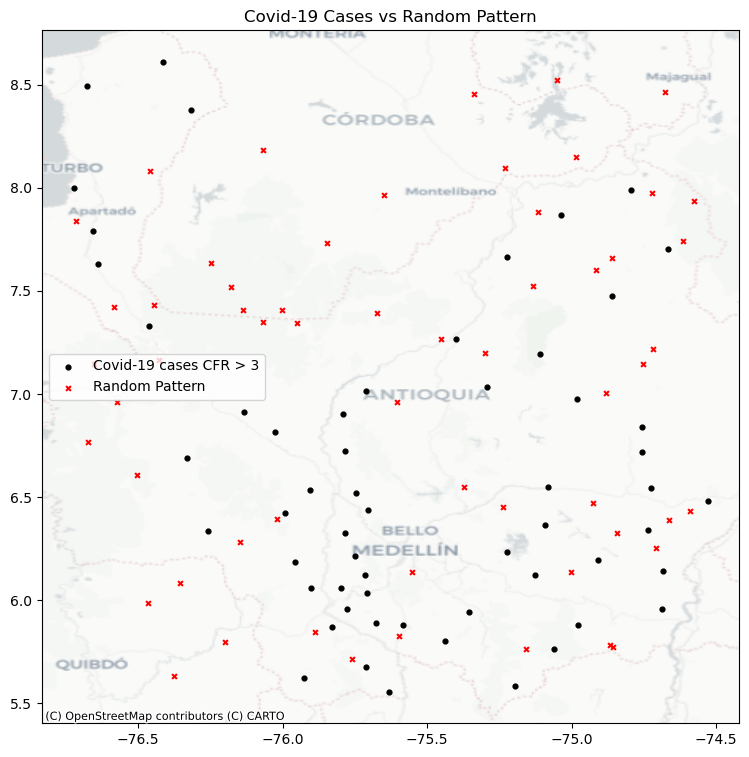

In [170]:
f, ax = plt.subplots(figsize=(9, 9))

plt.scatter(*coords.T, color='k', marker='o', s=12, label='Covid-19 cases CFR > 3')
plt.scatter(*random_pattern.T, color='r', marker='x', s=12, label='Random Pattern')

ctx.add_basemap(
    ax, crs="EPSG:4326",
    source=ctx.providers.CartoDB.Positron)
ax.legend(ncol=1, loc='center left')
ax.set_title('Covid-19 Cases vs Random Pattern')
plt.show()

In [185]:
random_pattern_ashape = random.poisson(alpha_shape, size=len(coords))

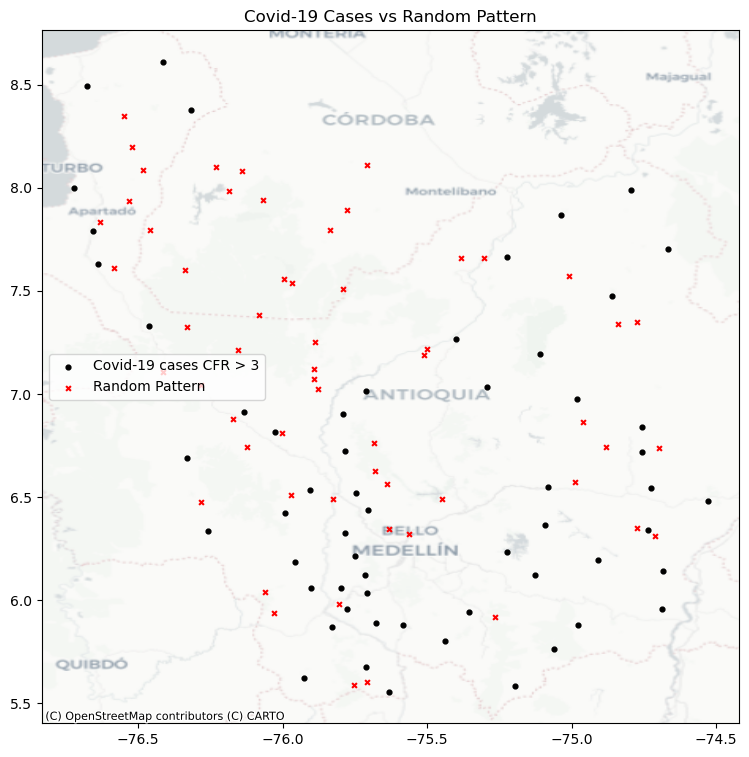

In [186]:
f, ax = plt.subplots(figsize=(9, 9))

plt.scatter(*coords.T, color='k', marker='o', s=12, label='Covid-19 cases CFR > 3')
plt.scatter(*random_pattern_ashape.T, color='r', marker='x', s=12, label='Random Pattern')

ctx.add_basemap(
    ax, crs="EPSG:4326",
    source=ctx.providers.CartoDB.Positron)
ax.legend(ncol=1, loc='center left')
ax.set_title('Covid-19 Cases vs Random Pattern')
plt.show()

### Quadrat Statistics

In [ ]:
qstat = QStatistic(coords, nx=2, ny=2)

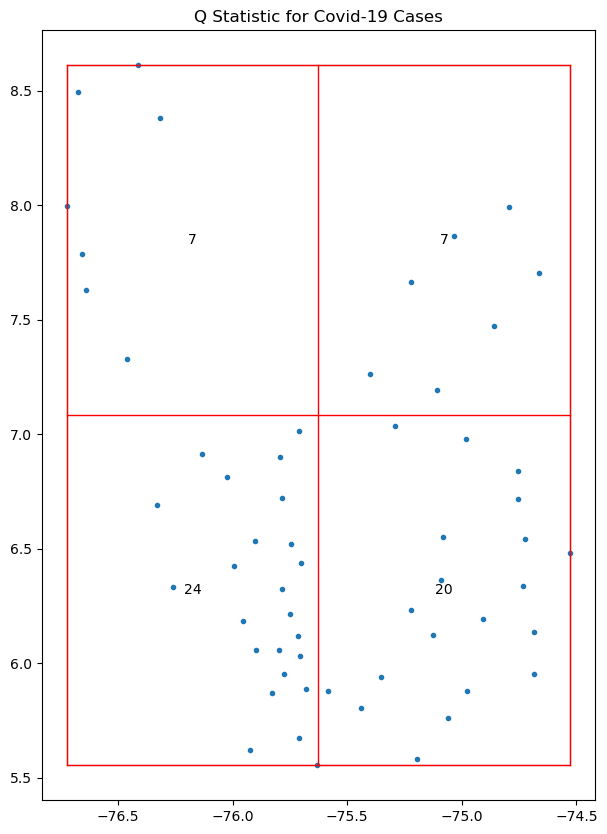

In [180]:
qstat.plot()
plt.title("Q Statistic for Covid-19 Cases")
plt.gcf().set_size_inches(10, 10)  # manually set figsize
plt.show()

In [181]:
qstat.chi2_pvalue

np.float64(0.001097656029624474)

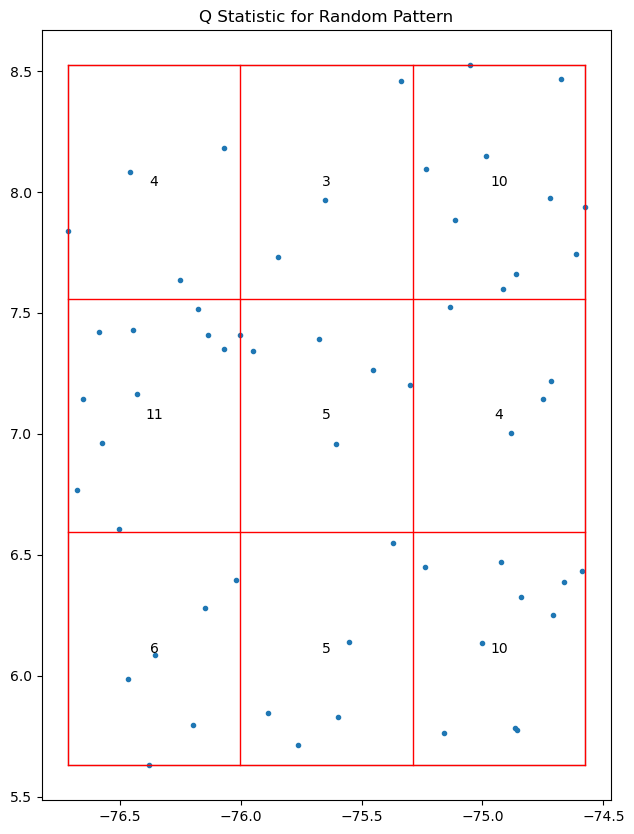

In [182]:
qstat_null = QStatistic(random_pattern)
qstat_null.plot()
plt.title("Q Statistic for Random Pattern") 
plt.gcf().set_size_inches(10, 10)  # manually set figsize   
plt.show()

In [183]:
qstat_null.chi2_pvalue

np.float64(0.17407762135254606)

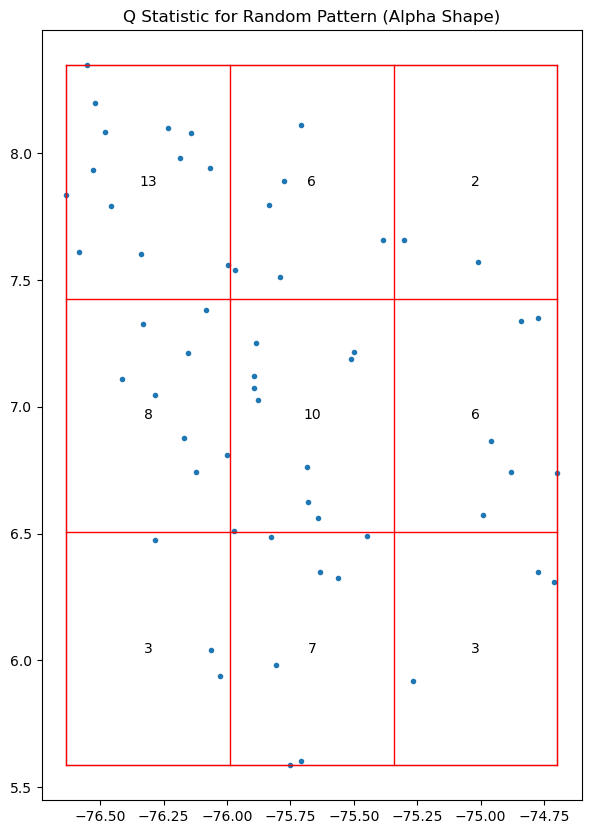

In [190]:
qstat_null_ashape = QStatistic(random_pattern_ashape)
qstat_null_ashape.plot()
plt.title("Q Statistic for Random Pattern (Alpha Shape)")
plt.gcf().set_size_inches(10, 10)  # manually set figsize
plt.show()

In [191]:
qstat_null_ashape.chi2_pvalue

np.float64(0.04439741847894219)

### Ripley's alphabet of functions

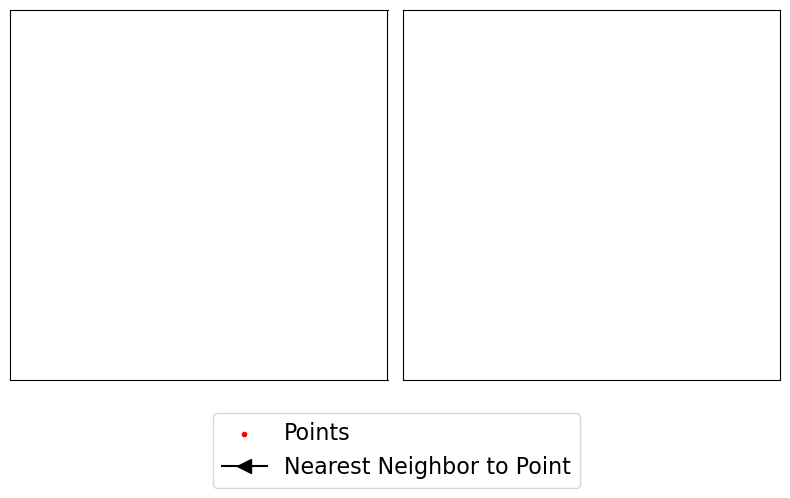

In [198]:
# this code should be hidden in the book, and only the plot visible!
f,ax = plt.subplots(1,2,figsize=(8,4), sharex=True, sharey=True)
ax[0].scatter(*random_pattern.T, color='red')
ax[1].scatter(*random_pattern.T, color='red',
              zorder=100, marker='.', label='Points')
nn_ixs, nn_ds = PointPattern(random_pattern).knn(1)
first = True
for coord, nn_ix, nn_d in zip(random_pattern, nn_ixs, nn_ds):
    dx, dy = random_pattern[nn_ix].squeeze() - coord
    arrow = ax[1].arrow(*coord, dx,dy, 
                length_includes_head=True, 
                overhang=0, head_length=300*3,
                head_width=300*3, width=50*3,
                linewidth=0, facecolor='k',
                head_starts_at_zero=False)
    if first:
        plt.plot((1e100, 1e101), (0,1), color='k', 
                 marker='<', markersize=10,
                 label='Nearest Neighbor to Point')
    first = False

ax[0].axis([1.554e7, 1.556e7, 4240000, 4260000])
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].set_xticks([])
ax[0].set_yticks([])
f.tight_layout()
ax[1].legend(bbox_to_anchor = (.5,-.06), fontsize=16)
plt.show()

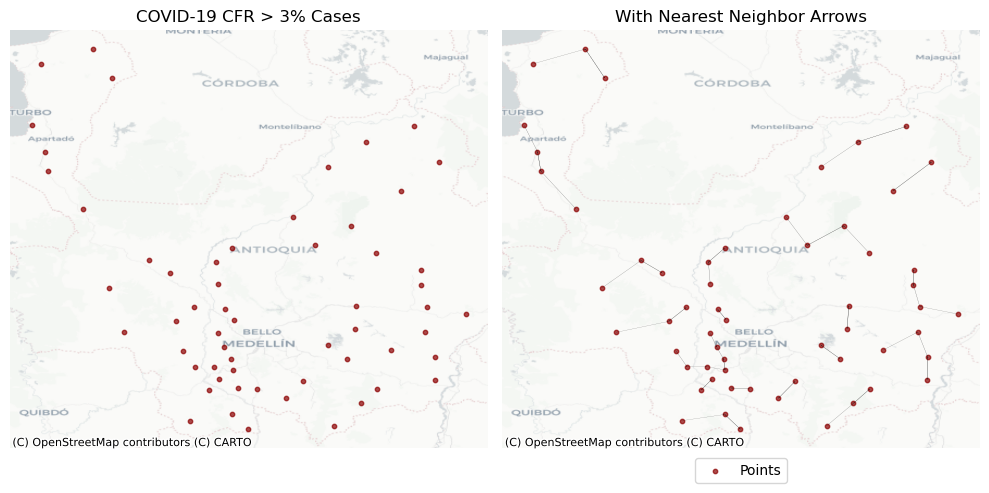

In [196]:
import matplotlib.pyplot as plt
import contextily as ctx
from pointpats import PointPattern
import numpy as np

# Assume you already have coords_3857 from CFR3_points_3857
# Example:
# CFR3_points_3857 = CFR3_points.to_crs(epsg=3857)
# coords_3857 = np.column_stack((CFR3_points_3857.geometry.x, CFR3_points_3857.geometry.y))

coords = coords_3857  # your projected points

# 1. Compute Nearest Neighbors
pp = PointPattern(coords)
nn_ixs, nn_ds = pp.knn(1)

# 2. Create subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

# ---- Panel 1: Points only
ax[0].scatter(*coords.T, color='darkred', alpha=0.7, s=10)
ctx.add_basemap(ax[0], crs="EPSG:3857", source=ctx.providers.CartoDB.Positron)
ax[0].set_title("COVID-19 CFR > 3% Cases")

# ---- Panel 2: Points + Arrows
ax[1].scatter(*coords.T, color='darkred', alpha=0.7, s=10, label='Points')
for coord, nn_ix in zip(coords, nn_ixs):
    dx, dy = coords[nn_ix].squeeze() - coord  # ✅ FIXED
    ax[1].arrow(*coord, dx, dy,
                length_includes_head=True,
                overhang=0, head_length=900,
                head_width=900, width=150,
                linewidth=0, facecolor='black',
                head_starts_at_zero=False, alpha=0.6)
ctx.add_basemap(ax[1], crs="EPSG:3857", source=ctx.providers.CartoDB.Positron)
ax[1].set_title("With Nearest Neighbor Arrows")

# 3. Clean up axes
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.set_axis_off()

# 4. Legend and layout
ax[1].legend(loc='lower center', bbox_to_anchor=(0.5, -0.1), fontsize=10)
fig.tight_layout()
plt.show()


### Identifying clusters

#### DBSCAN clustering

In [199]:
from sklearn.cluster import DBSCAN

In [200]:
clusterer = DBSCAN()

clusterer.fit(CFR3_points[["longitude", "latitude"]])

DBSCAN()

In [201]:
clusterer.core_sample_indices_[:5]

array([0, 1, 2, 3, 4])

In [202]:
clusterer.labels_[:5]

array([0, 0, 0, 0, 0])

In [203]:
lbls = pd.Series(clusterer.labels_, index=CFR3_points.index)

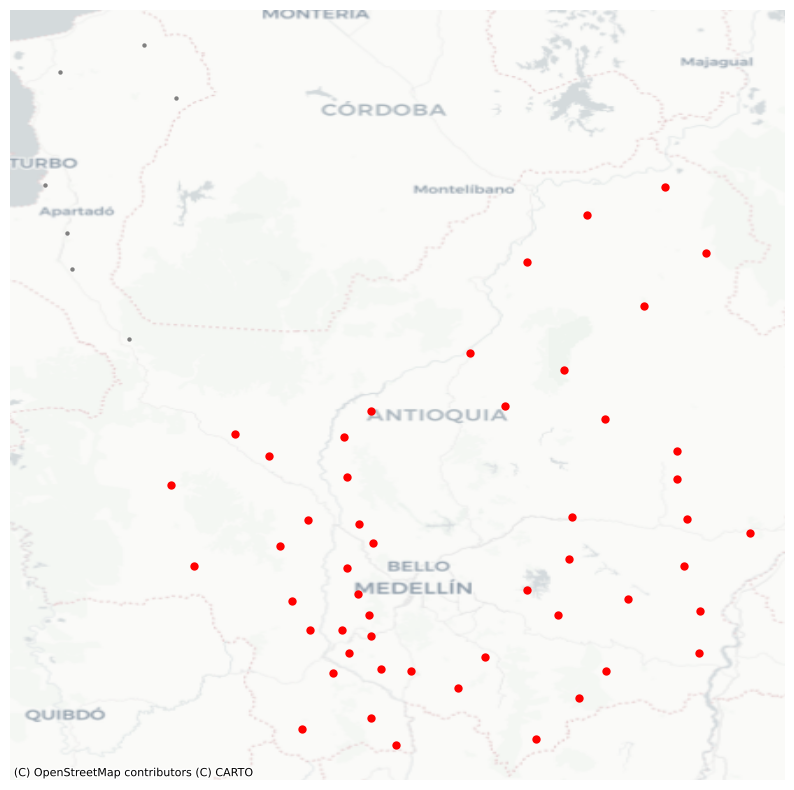

In [204]:
f, ax = plt.subplots(figsize=(10, 10))

noise = CFR3_points.loc[lbls == -1, ["longitude", "latitude"]]

ax.scatter(noise['longitude'], noise['latitude'], c='grey', s=10, linewidths=0)

ax.scatter(CFR3_points.loc[CFR3_points.index.difference(noise.index), 'longitude'],
           CFR3_points.loc[CFR3_points.index.difference(noise.index), 'latitude'],
           c='red', linewidths=0)

ctx.add_basemap(
    ax, crs="EPSG:4326",
    source=ctx.providers.CartoDB.Positron)

ax.set_axis_off()
plt.show()